In [20]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

from tqdm import tqdm_notebook

from nflib.flows import (
    AffineConstantFlow, ActNorm, AffineHalfFlow,
    SlowMAF, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel,
)
from nflib.utils import (plot_model, ConstrainedGaussian, DatasetMoons, WeirdConstrainedGaussian, 
                           DatasetSIGGRAPH, DatasetMixture, ConstrainedGaussianInner)
from nflib.spline_flows import NSF_AR, NSF_CL

# for auto-reloading external 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


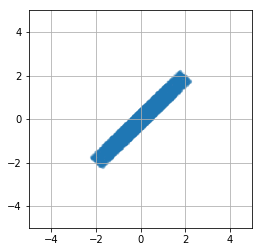

In [21]:
# Lightweight datasets
d = ConstrainedGaussianInner()
# d = ConstrainedGaussian()
# d = DatasetMoons()
# d = WeirdConstrainedGaussian()
# d = DatasetSIGGRAPH()
# d = DatasetMixture()
d.plot(10000)

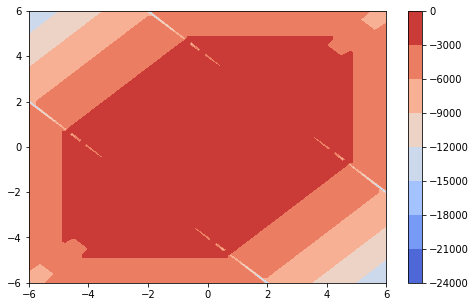

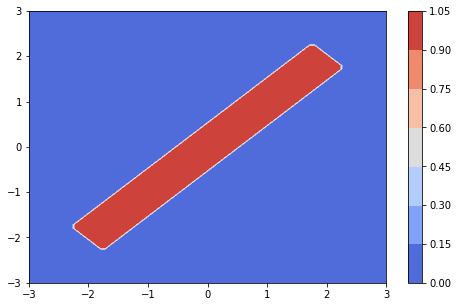

In [22]:
import scipy.stats as st

####### For 4 plots
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# axes = axes.flatten()

# for i, ax in enumerate(axes):
#     xx, yy = np.mgrid[-6:6:100j, -6:6:100j]
#     positions = torch.tensor(np.vstack([xx.ravel(), yy.ravel()])).float().T

#     conts = torch.zeros((len(positions), 4)).float()
#     conts[:, i] = 1

#     ll = np.exp(d.eval_constraints(positions, conts))

#     f = np.reshape(ll, xx.shape)

#     ax.set_xlim(-6, 6)
#     ax.set_ylim(-6, 6)
#     cfset = ax.contourf(xx, yy, f, cmap='coolwarm')

####### For 1 plot
fig, ax = plt.subplots(1,1, figsize=(8, 5))  
xx, yy = np.mgrid[-6:6:100j, -6:6:100j]
positions = torch.tensor(np.vstack([xx.ravel(), yy.ravel()])).float().T
# ll = np.exp(d.eval_constraints(positions, None))
ll = (d.eval_constraints(positions, None))
# ll[ll < -5] = -5s
f = np.reshape(ll, xx.shape)
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
fig.colorbar(cfset, orientation='vertical')    
plt.show()

fig, ax = plt.subplots(1,1, figsize=(8, 5))  
xx, yy = np.mgrid[-3:3:100j, -3:3:100j]
positions = torch.tensor(np.vstack([xx.ravel(), yy.ravel()])).float().T
ll = np.exp(d.eval_constraints(positions, None))
# ll = (d.eval_constraints(positions, None))
# ll[ll != 0] = -1
# ll[ll < -3] = -3
f = np.reshape(ll, xx.shape)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
fig.colorbar(cfset, orientation='vertical')    
plt.show()

In [23]:
# construct a model
def build_model(num_layers=3, baseline=False):
    conditioning = False
    prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
# prior = TransformedDistribution(Uniform(torch.zeros(2), torch.ones(2)), 
#                             SigmoidTransform().inv) # Logistic distribution

    if not baseline:
        # RealNVP
        flows = [AffineHalfFlow(dim=2, parity=i%2, 
                        conditioning=conditioning, num_conditioning=4) for i in range(num_layers)]

# NICE
# flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False) for i in range(10)]
# flows.append(AffineConstantFlow(dim=2, shift=False))

# SlowMAF (MAF, but without any parameter sharing for each dimension's scale/shift)
# flows = [SlowMAF(dim=2, parity=i%2) for i in range(8)]

# MAF (with MADE net, so we get very fast density estimation)
# flows = [MAF(dim=2, parity=i%2) for i in range(10)]

# IAF (with MADE net, so we get very fast sampling)
# flows = [IAF(dim=2, parity=i%2) for i in range(3)]

# insert ActNorms to any of the flows above
# norms = [ActNorm(dim=2) for _ in flows]
# flows = list(itertools.chain(*zip(norms, flows)))

# Glow paper
# flows = [Invertible1x1Conv(dim=2) for i in range(3)]
# norms = [ActNorm(dim=2) for _ in flows]
# couplings = [AffineHalfFlow(dim=2, parity=i%2, nh=32) for i in range(len(flows))]
# flows = list(itertools.chain(*zip(norms, flows, couplings))) # append a coupling layer after each 1x1
    else:
        # Neural splines, coupling
        nfs_flow = NSF_CL 
        # nfs_flow = NSF_AR
        flows = [nfs_flow(dim=2, K=8, B=3, hidden_dim=16) for _ in range(num_layers)]
        convs = [Invertible1x1Conv(dim=2) for _ in flows]
        norms = [ActNorm(dim=2) for _ in flows]
        flows = list(itertools.chain(*zip(norms, convs, flows)))

    return NormalizingFlowModel(prior, flows, conditioning=conditioning)
# construct the model

We assume there is some generating distribution $p(x)$ that and we observe some limited sample of size $K$ i.i.d from $p(x)$. Our goal is to build a model $p_{x}(x, \theta) \approx p(x)$. I have chosen to model $p_{x}(x; \theta)$ by a normalizing flow where we assume  $p_{x}(x; \theta)$ is a transformation of a simple distribution $p_u(u)$. If $T$ is invertible and both $T$ and $T^{-1}$ are differentiable, $p_{x}(x; \theta)$ is a well defined density: 

$$
p_{x}(x, \theta) = p_u(u) \mid det J_T(u) \mid^{-1} = p_u(T^{-1}(x)) \mid det J_{T^{-1}}(x) \mid
$$

### Forward KL Divergence
We can choose to minimize the KL between the target distribution $p(x)$ and the approximation $p_x(x, \theta)$.

$$
\mathcal{L}(\theta) = D_{KL} ( p(x) || p_x(x, \theta) ) \\ 
= - \mathbb{E}_{p(x)} [log (p_x(x, \theta))] + const \\
= - \mathbb{E}_{p(x)} [log(p_u(T^{-1}(x)) + log | det J_{T^{-1}}(x) |] + const
$$

Here note that we need the following:

- samples from $p(x)$ and;
- the ability to evaluate the base distribution $p(u)$ and efficiently perform the transformation $T^{-1}$

### Backward KL Divergence
We can choose to minimize the KL between the  approximation $p_x(x, \theta)$ and the target distribution $p(x)$.

$$
\mathcal{L}(\theta) = D_{KL} ( p_x(x, \theta) ||  p(x) ) \\ 
= - \mathbb{E}_{p_x(x, \theta)} [log (p_x(x, \theta)) - log p(x)] \\
= - \mathbb{E}_{p(u)} [log(p_u(u)) - log | det J_{T}(u) | - log p(T(u))]
$$

Here we need:
- samples from the base distribution p(u)
- ability to evaluate (efficiently) the transformation T
- ability to evaluate the target distribution density (up to a proportionality constant) $p(x)$

##### What if we don't know $p(x)$ but we do know constraints?

Let us assume: $p(x) = \frac{1}{Z} p'(x) c(x)$ where $c$ defines some constraints on the domain on $x$, $Z$ is some normalizing constant and $p'$ is the target density that is valid in the constraints (and is unknown).

We now have that $log p(x) = -log Z + log p'(x) + log c(x)$. If the constraints are such that $c \propto 1$ when $c$ is SAT and $c << p$ when $c$ is UNSAT we can see that: 

$$
log p(x) \approx 
\begin{cases}
    log p'(x) + const,   & SAT(c(x))\\
    log c(x)  + const,   & \text{otherwise}
\end{cases} 
$$

In [36]:
from torch.nn.utils import clip_grad_norm_

def train(model, d, optimizer, scheduler, back_kl=False, forward_kl=True, n_data=1000, 
          store_test=True, test_model=None, batch_size=128, n_epochs=1000, no_const_test=False):
    model.train()
    
    x_ = d.sample(n_data)
    x_test = d.sample(1000)

    train_statistics = []

    for k in tqdm_notebook(range(n_epochs)):
        
        loss = 0
        if forward_kl:
            
            x = x_[np.random.choice(range(n_data), size=np.min([n_data, batch_size]), replace=False)]
            zs, prior_logprob, log_det = model(x)

            logprob = prior_logprob + log_det
            loss_fwd = -torch.sum(logprob) # NLL
            loss += loss_fwd
            
        if back_kl:
            num_samples = np.min([k+1, batch_size])
            z = model.prior.sample((num_samples,))
            
            xs, log_det_back = model.backward(z)
            
            predictions = xs[-1]
            
            unnorm_post_logprob = d.eval_constraints(predictions, None)
            loss_bkwd = -(torch.sum(unnorm_post_logprob) + log_det_back.sum())            
            
            loss += loss_bkwd
        
        model.zero_grad()    
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        if (k % 10 == 0) and store_test:
            
            zs, prior_logprob_test, log_det_test = model(x_test) 
            loss_fwd_model = -torch.sum(prior_logprob_test + log_det_test)
            
            z = model.prior.sample((1000,))
            xs, log_det = model.backward(z)
            back_loss_pred = d.eval_constraints(xs[-1], None)
            
            zs, prior_logprob, log_det = test_model(xs[-1])
            loss_fwd = -torch.sum(prior_logprob + log_det)
            
            train_statistics.append({
                'est_gen_loss': loss_fwd.item(),
                'fwd_loss': loss_fwd_model.item(),
                'broken_constraints': (~d.hard_constraint(xs[-1])).sum().item(),
                'back_loss': -back_loss_pred.sum().item()
            })

        if k % 100 == 1:
            if back_kl:
                print(loss_fwd.item(), loss_bkwd.item())
            else:
                print(loss_fwd.item())
    return train_statistics

In [37]:
def make_optimizer(model):
    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3) # todo tune WD
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)
    print("number of params: ", sum(p.numel() for p in model.parameters()))
    return optimizer, scheduler

In [38]:
baseline = build_model(num_layers=10, baseline=True)
optimizer, scheduler = make_optimizer(baseline)
no_back_kl_stats = train(baseline, d, optimizer, scheduler, 
                         back_kl=False, n_data=10000, store_test=False,
                         batch_size=500, n_epochs=1500)

number of params:  19480


840.7207641601562
710.9515380859375
696.0658569335938
689.1961669921875
689.7080078125
690.7691650390625
671.9468994140625
674.0986938476562
681.7977294921875
673.8148803710938
666.58935546875
688.9484252929688
687.3087158203125
689.3204345703125
677.743408203125



# generated: 5000
# broken constraint: 48
% broken constraint: 0.0096


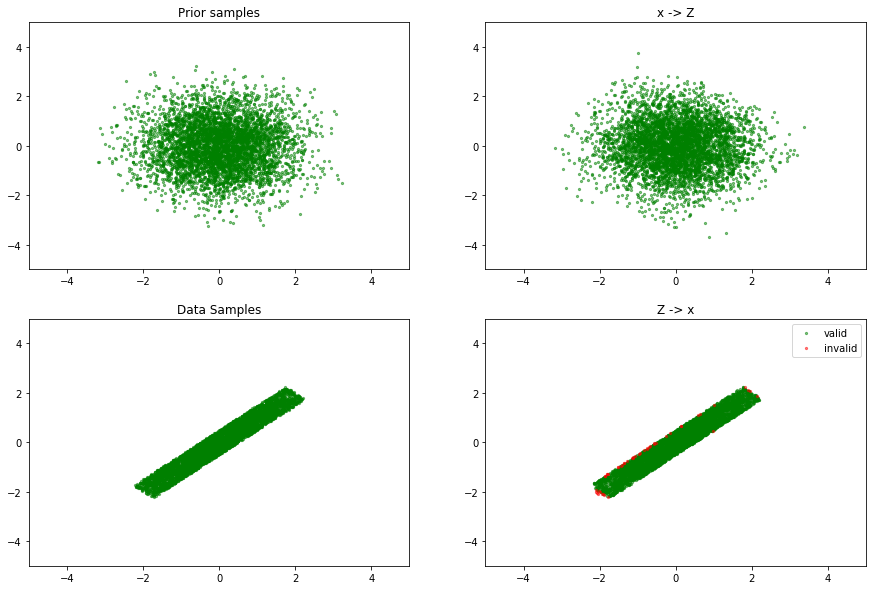

In [39]:
baseline.eval()
plot_model(d, baseline, constraint=d.hard_constraint)

In [40]:
model_plus_back_kl = build_model(baseline=True, num_layers=5)
optimizer, scheduler = make_optimizer(model_plus_back_kl)
plus_back_kl_stats = train(model_plus_back_kl, d, optimizer, scheduler, 
                           back_kl=True, n_data=500, 
                           test_model=baseline, batch_size=100, n_epochs=1500)

number of params:  9740


182.66610717773438 2.094468116760254
170.40994262695312 249.1925506591797
150.2207794189453 787.05078125
135.30389404296875 227.54029846191406
147.65249633789062 331.4861145019531
139.7707977294922 207.07704162597656
132.7698516845703 217.5726318359375
128.4425048828125 247.44570922851562
132.72171020507812 183.16549682617188
129.37454223632812 150.08486938476562
131.94061279296875 253.9388427734375
131.34132385253906 192.20401000976562
134.6645050048828 403.55316162109375
135.30653381347656 275.86761474609375
130.25318908691406 228.7452392578125



# generated: 5000
# broken constraint: 68
% broken constraint: 0.0136


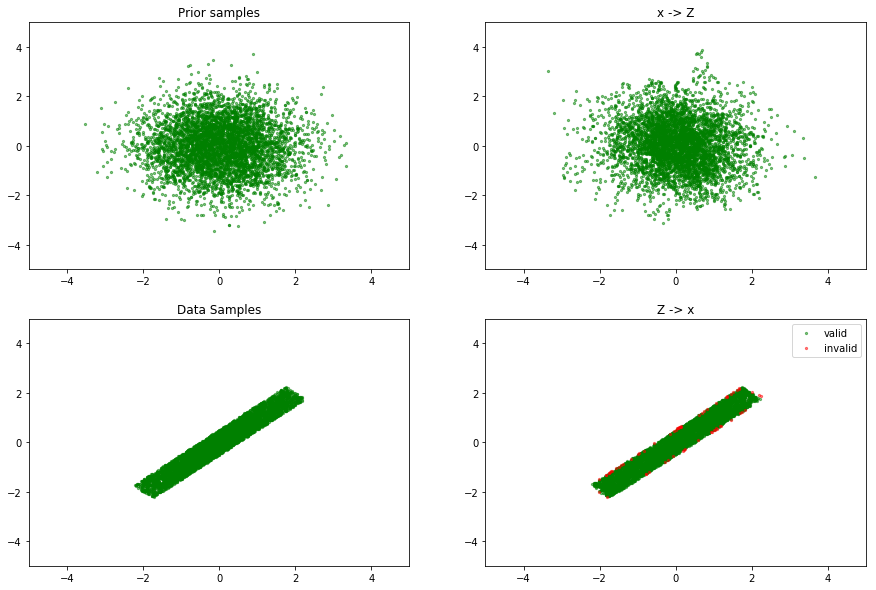

In [41]:
model_plus_back_kl.eval()
plot_model(d, model_plus_back_kl, constraint=d.hard_constraint)

In [42]:
# construct the model
model_no_back_kl = build_model(baseline=True, num_layers=5)
optimizer, scheduler = make_optimizer(model_no_back_kl)
no_back_kl_stats = train(model_no_back_kl, d, optimizer, 
                         scheduler, back_kl=False, n_data=500, 
                         test_model=baseline, batch_size=100, n_epochs=1500)

number of params:  9740


186.99224853515625
154.4898223876953
144.35377502441406
138.1287078857422
132.8872833251953
129.8451385498047
131.51502990722656
123.82978057861328
131.7940216064453
128.39854431152344
131.61842346191406
122.39105987548828
123.13011932373047
137.44833374023438
120.74407958984375



# generated: 5000
# broken constraint: 89
% broken constraint: 0.0178


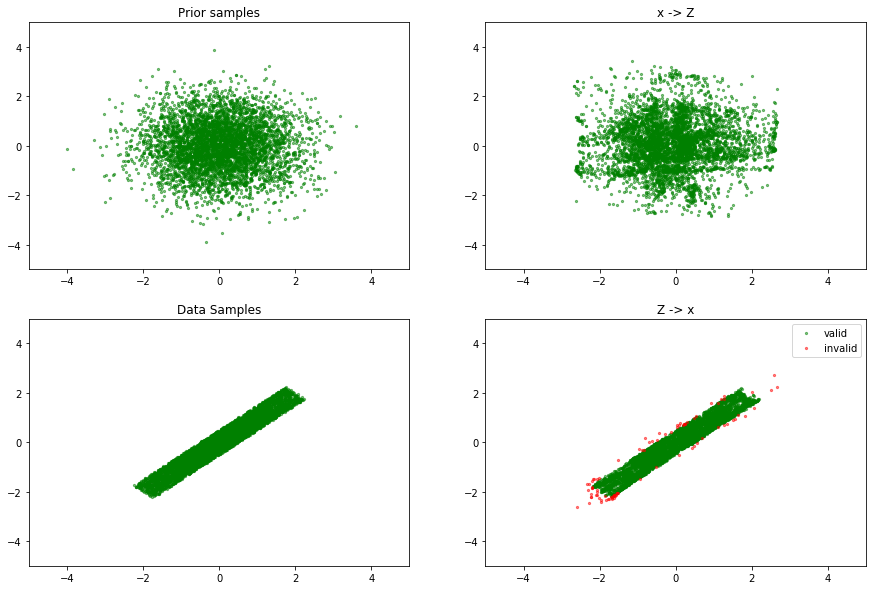

In [43]:
model_no_back_kl.eval()
plot_model(d, model_no_back_kl, constraint=d.hard_constraint)
# plot_model(d, model, constraint=d.rest0, conditioning=True, index=0)

In [45]:
model_plus_back_kl_bad_learn = build_model(baseline=True, num_layers=5)
optimizer, scheduler = make_optimizer(model_plus_back_kl_bad_learn)
only_back_kl_stats = train(model_plus_back_kl_bad_learn, d, optimizer, 
                           scheduler, back_kl=True, n_data=2, forward_kl=True,
                           test_model=baseline, batch_size=100, n_epochs=1500, no_const_test=False)

number of params:  9740


-0.23132586479187012 4.61196231842041
2.902008295059204 192.06283569335938
2.5147624015808105 368.5807189941406
2.8338422775268555 263.2186279296875
2.6917977333068848 215.12796020507812
2.1827645301818848 205.4219970703125
2.3693976402282715 212.15066528320312
2.2318570613861084 192.358642578125
1.6940258741378784 289.9093017578125
1.7944391965866089 162.73536682128906
1.7098289728164673 161.43411254882812
1.980381965637207 137.0004119873047
1.7892025709152222 136.9313201904297
2.0682055950164795 175.61599731445312
2.0169267654418945 206.65402221679688



# generated: 5000
# broken constraint: 40
% broken constraint: 0.008


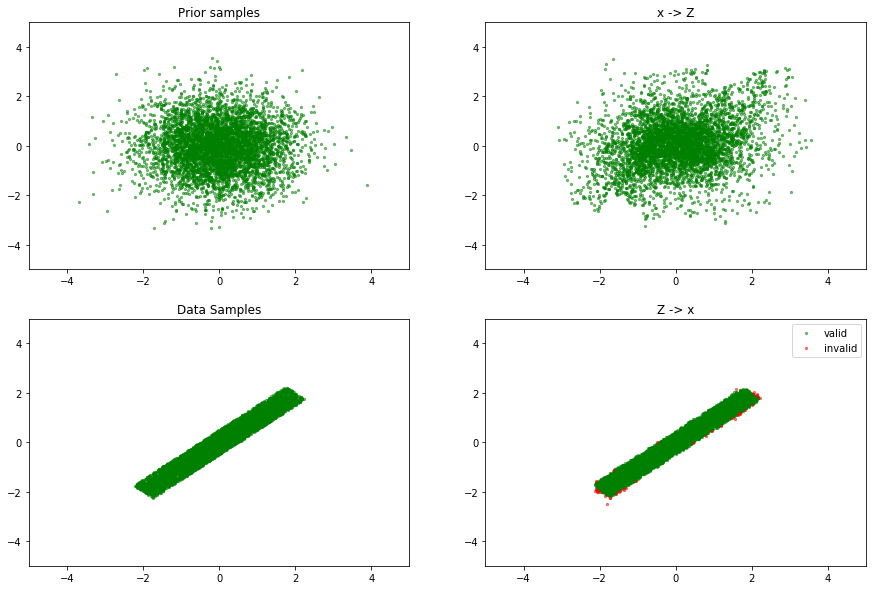

In [46]:
model_plus_back_kl_bad_learn.eval()
plot_model(d, model_plus_back_kl_bad_learn, constraint=d.hard_constraint)

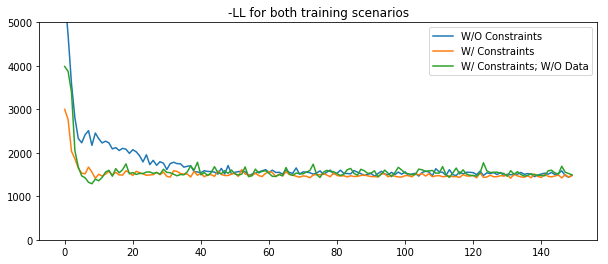

In [50]:
df_1 = pd.DataFrame(no_back_kl_stats)
df_2 = pd.DataFrame(plus_back_kl_stats)
df_3 = pd.DataFrame(only_back_kl_stats)

plt.figure(figsize=(10,4))
df_1.est_gen_loss.plot(label='W/O Constraints')
df_2.est_gen_loss.plot(label='W/ Constraints')
df_3.est_gen_loss.plot(label='W/ Constraints; W/O Data')
plt.legend(loc='best')
plt.title("-LL for both training scenarios")

plt.ylim([0,5000])
plt.show()

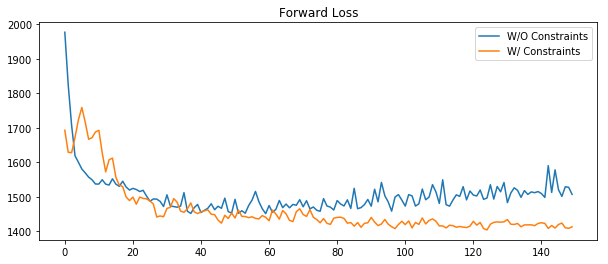

In [52]:
plt.figure(figsize=(10,4))
df_1.fwd_loss.plot(label='W/O Constraints')
df_2.fwd_loss.plot(label='W/ Constraints')
# df_3.fwd_loss.plot(label='W/ Constraints; W/O Data')
plt.legend(loc='best')
plt.title("Forward Loss")
plt.show()

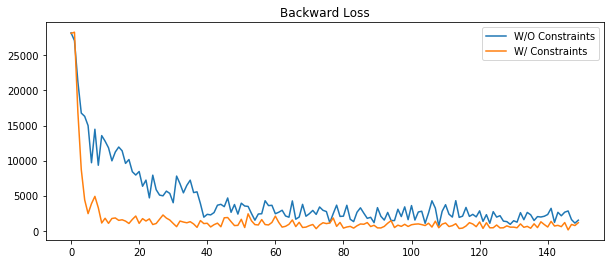

In [54]:
plt.figure(figsize=(10,4))
df_1.back_loss.plot(label='W/O Constraints')
df_2.back_loss.plot(label='W/ Constraints')
# df_3.back_loss.plot(label='W/ Constraints; W/O Data')
plt.legend(loc='best')
plt.title("Backward Loss")
plt.show()

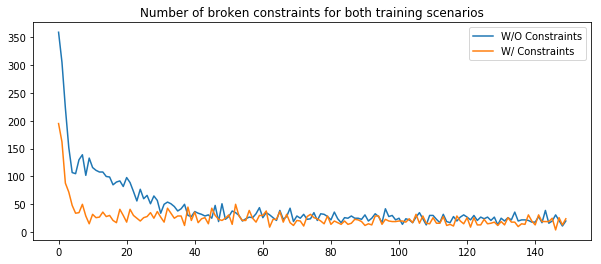

In [56]:
plt.figure(figsize=(10,4))
df_1.broken_constraints.plot(label='W/O Constraints')
df_2.broken_constraints.plot(label='W/ Constraints')
# df_3.broken_constraints.plot(label='W/ Constraints; W/O Data')
plt.legend(loc='best')
plt.title("Number of broken constraints for both training scenarios")
plt.show()

In [19]:
res = []
models_fwd = []
models_back = []
for n_samples, batch_size in zip([2**6, 2**7, 2**8, 2**9, 2**10, 2**11], 
                                 [2**6, 2**7, 2**7, 2**7, 2**8, 2**8]):
    
    print(n_samples, batch_size)
    
    models_fwd.append(build_model(baseline=True, num_layers=5))
    optimizer, scheduler = make_optimizer(models_fwd[-1])
    no_back_kl_stats = train(models_fwd[-1], d, optimizer, 
                             scheduler, back_kl=False, n_data=n_samples, 
                             test_model=baseline, batch_size=batch_size, n_epochs=1500)
    
    models_back.append(build_model(baseline=True, num_layers=5))
    optimizer, scheduler = make_optimizer(models_back[-1])
    back_kl_stats = train(models_back[-1], d, optimizer, 
                             scheduler, back_kl=True, n_data=n_samples, 
                             test_model=baseline, batch_size=batch_size, n_epochs=1500)
    
    res.append({
        'nsamps': n_samples, 
        'no_back_kl_stats': no_back_kl_stats, 
        'back_kl_stats': back_kl_stats})

64 64
number of params:  9740


100.67349243164062
52.020606994628906
21.244718551635742
11.846465110778809
-3.775217056274414
3.0248513221740723
-16.196243286132812
-29.13724136352539
-40.07441329956055
-8.454030990600586
-23.402851104736328
-38.37928771972656
-26.26866912841797
-32.974220275878906
-42.11174011230469

number of params:  9740


104.76097869873047 2.5544018745422363
88.3490982055664 95.32958984375
69.27132415771484 134.10195922851562
52.66975402832031 148.5865936279297
47.502220153808594 133.9847869873047
34.89375305175781 111.39510345458984
29.00381088256836 114.24083709716797
19.68636131286621 147.33340454101562
16.502880096435547 122.13914489746094
12.05032730102539 175.93228149414062
7.510562896728516 144.64263916015625
4.280388832092285 235.19400024414062
5.934062957763672 108.9324951171875
5.578393936157227 186.87930297851562
3.4818954467773438 116.54252624511719

128 128
number of params:  9740


227.041015625
150.1819610595703
121.40632629394531
99.5863037109375
91.10267639160156
78.47671508789062
80.12971496582031
64.32838439941406
72.62359619140625
77.77549743652344
48.62836456298828
46.637176513671875
40.03731155395508
55.000892639160156
32.170310974121094

number of params:  9740


239.96434020996094 32.960880279541016
205.03623962402344 316.0872497558594
157.84188842773438 447.1514892578125
136.03729248046875 258.0665283203125
130.04693603515625 284.03076171875
124.8997802734375 253.67105102539062
121.16732025146484 259.9770202636719
115.016845703125 303.86126708984375
112.4089584350586 562.9210815429688
106.78759765625 328.04718017578125
103.194580078125 255.59019470214844
98.67666625976562 370.267578125
104.02611541748047 417.78192138671875
96.09658813476562 219.5456085205078
91.06220245361328 308.48602294921875

256 128
number of params:  9740


199.88304138183594
173.56610107421875
167.41989135742188
156.28500366210938
159.44357299804688
147.18661499023438
162.44406127929688
142.67417907714844
143.7109375
151.37789916992188
143.47056579589844
138.02203369140625
124.31549835205078
139.899658203125
138.34764099121094

number of params:  9740


197.0561065673828 2.7819719314575195
167.86788940429688 697.6414794921875
159.71759033203125 196.03506469726562
155.29852294921875 244.08514404296875
149.5111541748047 190.59463500976562
150.49119567871094 232.97076416015625
141.43539428710938 374.59033203125
146.29986572265625 283.8353271484375
140.99777221679688 219.4197998046875
139.03076171875 316.587158203125
143.6072540283203 280.00958251953125
134.2223358154297 253.64373779296875
143.75697326660156 179.6358184814453
139.50648498535156 231.3051300048828
137.20562744140625 214.2672882080078

512 128
number of params:  9740


227.46409606933594
180.0743408203125
176.1334228515625
160.20306396484375
168.1360626220703
161.36337280273438
161.62863159179688
152.4641571044922
156.29786682128906
168.1461944580078
159.1425018310547
154.3203582763672
154.3583984375
157.5707550048828
148.31629943847656

number of params:  9740


278.2259826660156 41.452781677246094
199.12835693359375 293.1572265625
172.28274536132812 319.239013671875
173.35784912109375 204.34974670410156
176.8503875732422 294.7159118652344
173.7255859375 266.95147705078125
165.982666015625 251.68414306640625
170.02378845214844 874.4388427734375
165.30950927734375 301.244384765625
170.03231811523438 216.52345275878906
162.5381622314453 186.20753479003906
166.41929626464844 219.73194885253906
163.34414672851562 244.30398559570312
173.21412658691406 287.7121276855469
165.13848876953125 273.89019775390625

1024 256
number of params:  9740


438.84222412109375
369.50323486328125
348.7887878417969
342.0086364746094
332.4256896972656
338.4178466796875
344.5310363769531
338.3122863769531
335.30499267578125
327.44384765625
337.10400390625
337.17498779296875
319.3485107421875
318.5906982421875
337.9355773925781

number of params:  9740


433.111083984375 27.96462631225586
415.7828369140625 245.4268035888672
357.5804748535156 511.7108154296875
349.6199645996094 601.6151123046875
345.384521484375 1096.5819091796875
349.8211669921875 407.4709167480469
348.6663513183594 497.91607666015625
347.3530578613281 566.8330688476562
339.0754089355469 564.1768798828125
345.38568115234375 555.379150390625
350.7689208984375 568.7176513671875
343.3705749511719 694.75927734375
344.4673156738281 592.9212036132812
345.3101806640625 469.17364501953125
340.8694763183594 501.27301025390625

2048 256
number of params:  9740


659.125
404.9364013671875
375.7159423828125
366.858154296875
353.74365234375
353.9214172363281
352.00213623046875
354.6969909667969
351.087890625
351.43780517578125
363.452880859375
353.6961669921875
354.8174743652344
345.11328125
329.8912353515625

number of params:  9740


397.4311828613281 2.500401496887207
378.14874267578125 224.64944458007812
359.02850341796875 282.32232666015625
348.24725341796875 664.8727416992188
346.5044860839844 683.3914794921875
341.55157470703125 570.3214111328125
350.5795593261719 511.0904235839844
349.3182373046875 520.4675903320312
350.3799743652344 448.8349609375
343.96728515625 479.6586608886719
344.75689697265625 491.15887451171875
352.42974853515625 819.340576171875
348.7870788574219 604.0286865234375
344.3124694824219 523.103515625
347.4887390136719 654.01708984375



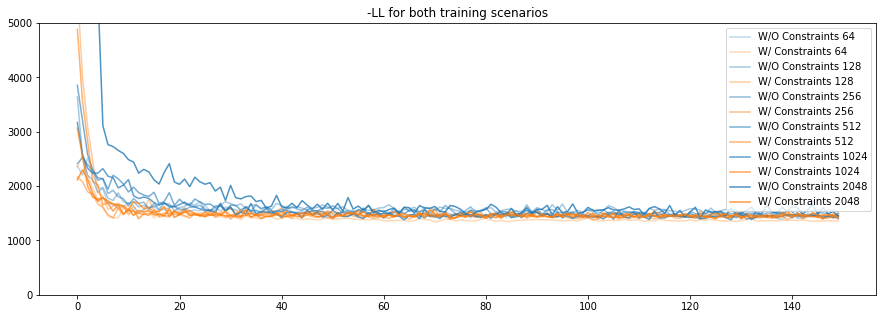

In [57]:
plt.figure(figsize=(15,5))

for i, data in enumerate(res):
    
    nsamps = data['nsamps']
    df_1 = pd.DataFrame(data['no_back_kl_stats'])
    df_2 = pd.DataFrame(data['back_kl_stats'])

    df_1.est_gen_loss.plot(label=f'W/O Constraints {nsamps}', c='C0', alpha=.3+i/10)
    df_2.est_gen_loss.plot(label=f'W/ Constraints {nsamps}', c='C1', alpha=.3+i/10)
    
plt.legend(loc='best')
plt.title("-LL for both training scenarios")
plt.ylim([0, 5000])
plt.show()

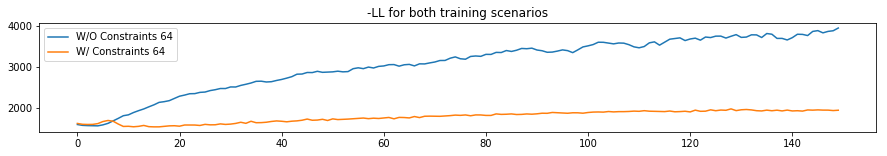

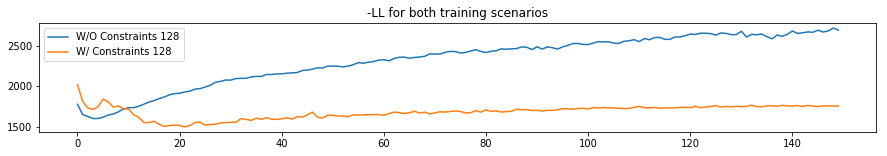

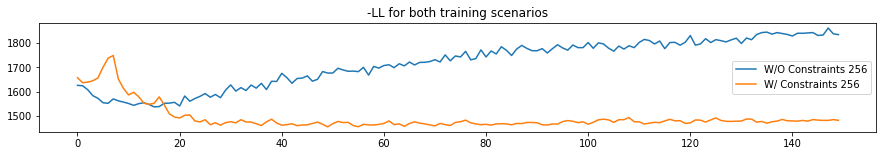

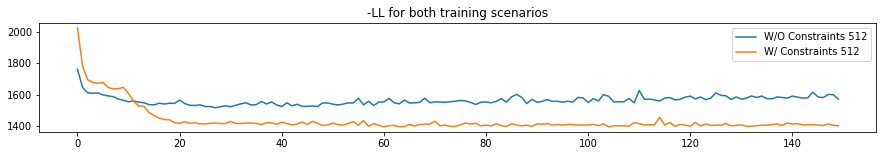

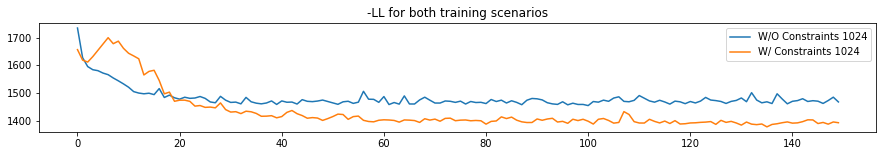

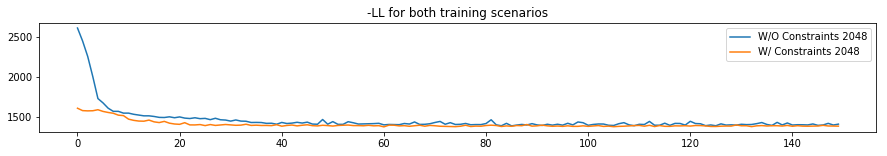

In [58]:
for i, data in enumerate(res):
    plt.figure(figsize=(15,2))
    nsamps = data['nsamps']
    df_1 = pd.DataFrame(data['no_back_kl_stats'])
    df_2 = pd.DataFrame(data['back_kl_stats'])

    df_1.fwd_loss.plot(label=f'W/O Constraints {nsamps}', c='C0')
    df_2.fwd_loss.plot(label=f'W/ Constraints {nsamps}', c='C1')
    
    plt.legend(loc='best')
    plt.title("-LL for both training scenarios")
    plt.show()

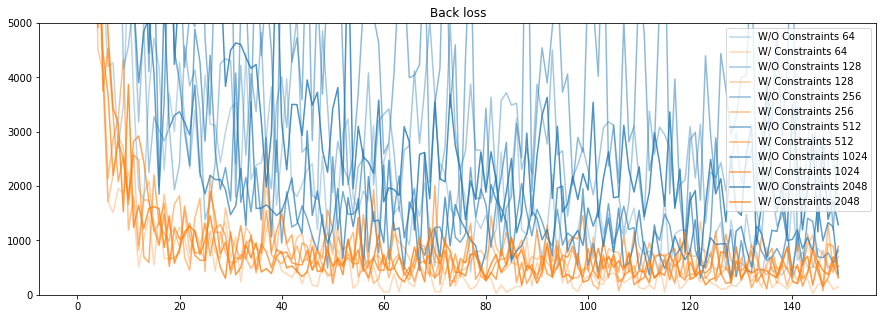

In [59]:
plt.figure(figsize=(15,5))

for i, data in enumerate(res):
    
    nsamps = data['nsamps']
    df_1 = pd.DataFrame(data['no_back_kl_stats'])
    df_2 = pd.DataFrame(data['back_kl_stats'])

    df_1.back_loss.plot(label=f'W/O Constraints {nsamps}', c='C0', alpha=.3+i/10)
    df_2.back_loss.plot(label=f'W/ Constraints {nsamps}', c='C1', alpha=.3+i/10)
#     df_1.est_loss_fwd.plot(label=f'W/O Constraints {nsamps}', c='C0', alpha=.3+i/10)
#     df_2.est_loss_fwd.plot(label=f'W/ Constraints {nsamps}', c='C1', alpha=.3+i/10)
    
plt.legend(loc='best')
plt.title("Back loss")
plt.ylim([0,5000])
plt.show()

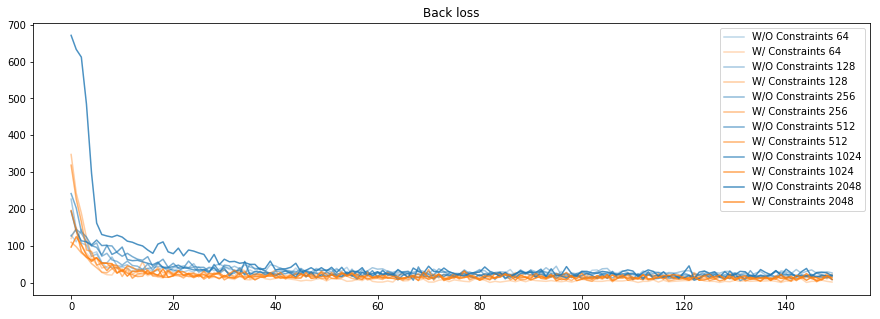

In [60]:
plt.figure(figsize=(15,5))

for i, data in enumerate(res):
    
    nsamps = data['nsamps']
    df_1 = pd.DataFrame(data['no_back_kl_stats'])
    df_2 = pd.DataFrame(data['back_kl_stats'])

    df_1.broken_constraints.plot(label=f'W/O Constraints {nsamps}', c='C0', alpha=.3+i/10)
    df_2.broken_constraints.plot(label=f'W/ Constraints {nsamps}', c='C1', alpha=.3+i/10)
#     df_1.est_loss_fwd.plot(label=f'W/O Constraints {nsamps}', c='C0', alpha=.3+i/10)
#     df_2.est_loss_fwd.plot(label=f'W/ Constraints {nsamps}', c='C1', alpha=.3+i/10)
    
plt.legend(loc='best')
plt.title("Back loss")
plt.show()

# generated: 5000
# broken constraint: 112
% broken constraint: 0.0224


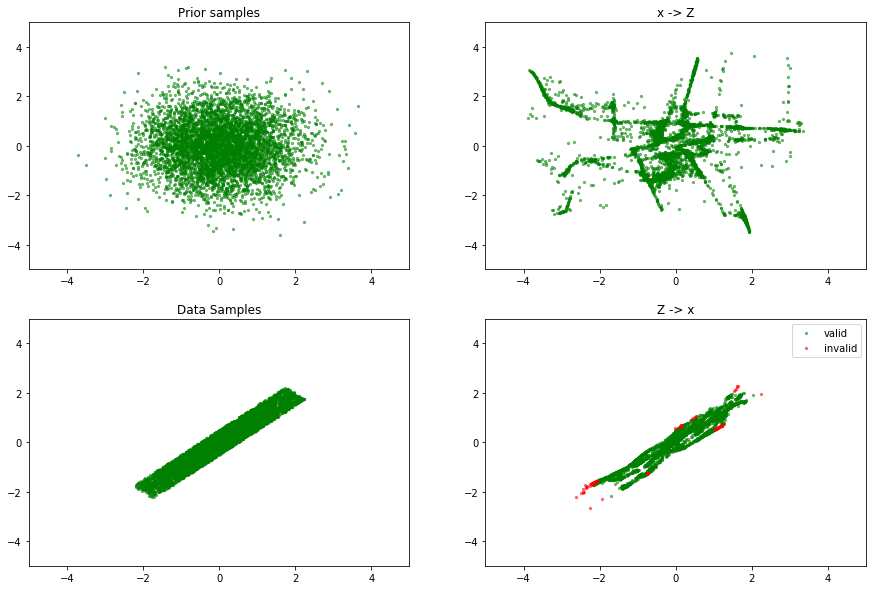

# generated: 5000
# broken constraint: 118
% broken constraint: 0.0236


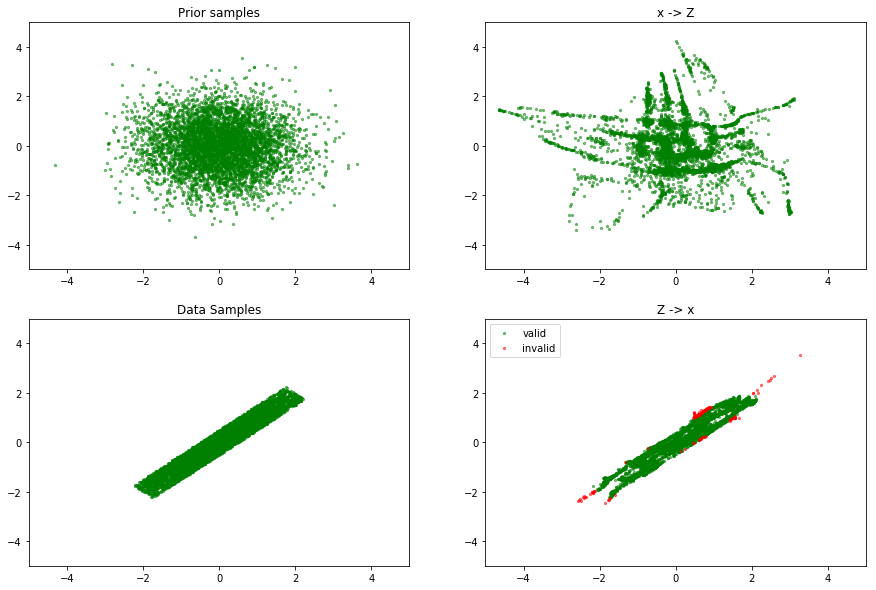

# generated: 5000
# broken constraint: 109
% broken constraint: 0.0218


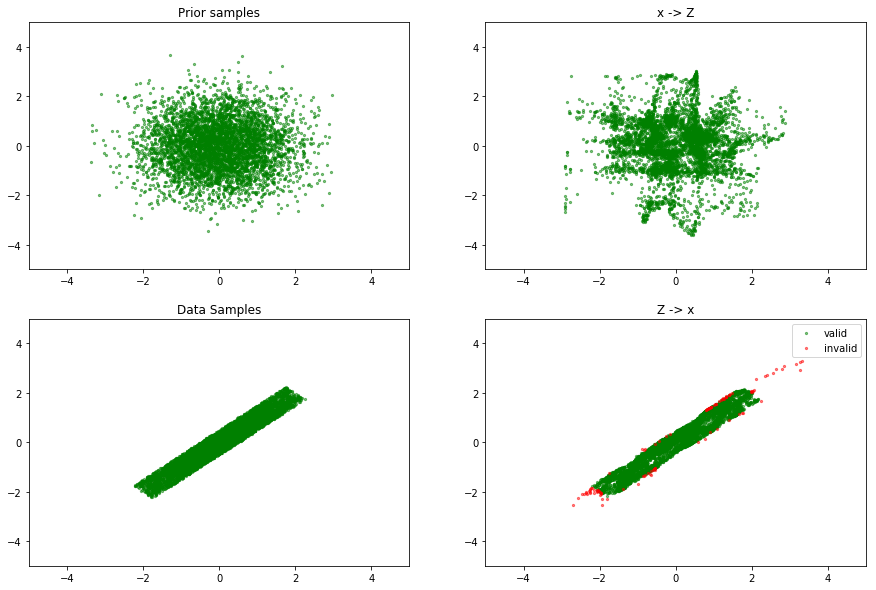

# generated: 5000
# broken constraint: 88
% broken constraint: 0.0176


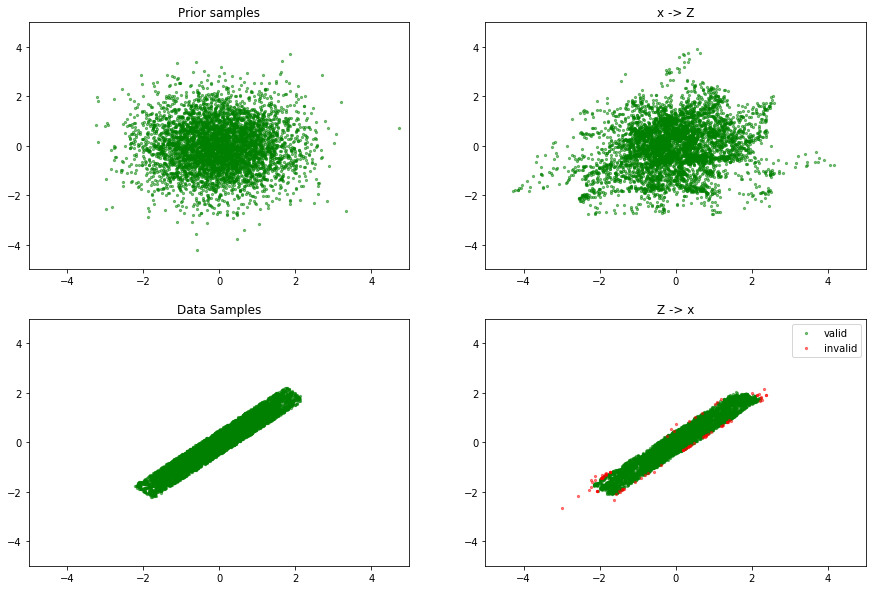

# generated: 5000
# broken constraint: 73
% broken constraint: 0.0146


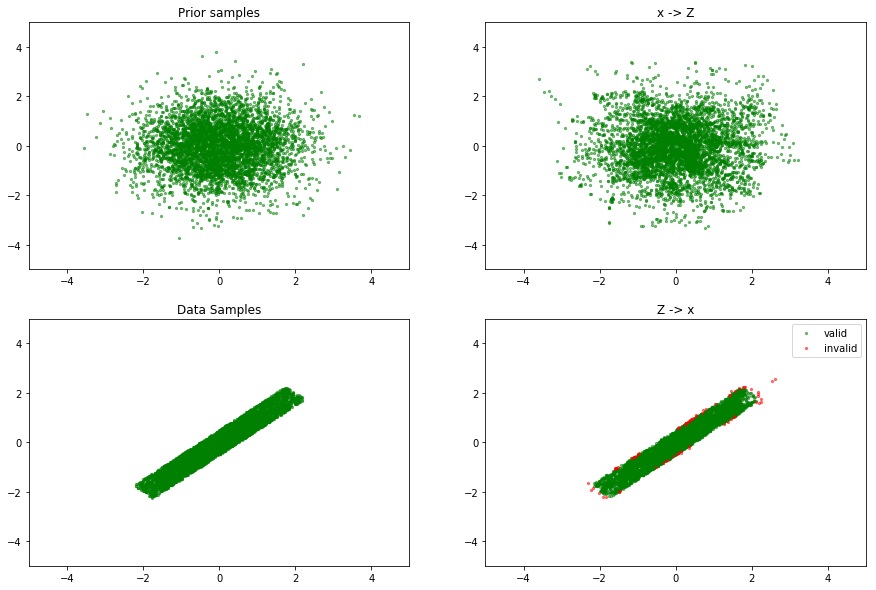

# generated: 5000
# broken constraint: 129
% broken constraint: 0.0258


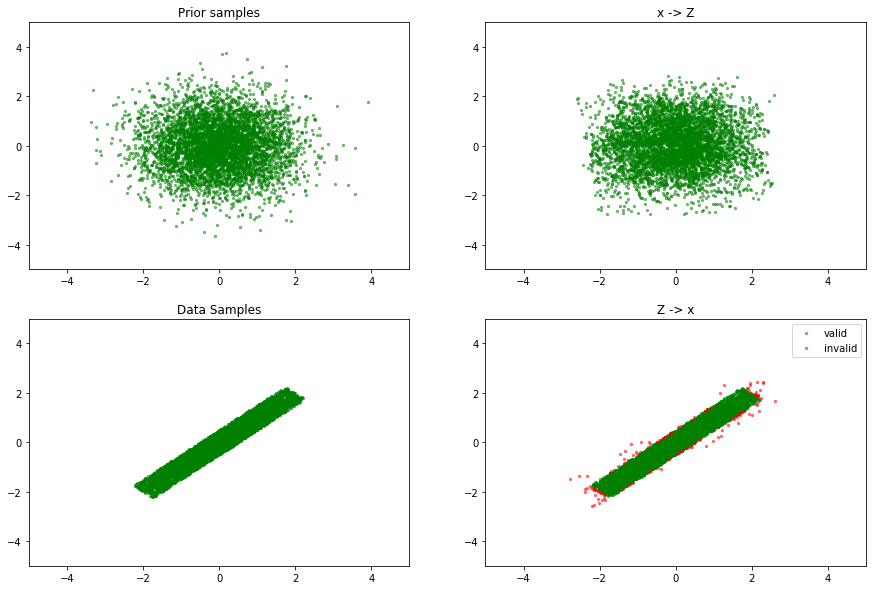

In [61]:
for mdl in models_fwd: 
#     mdl = build_model(baseline=True, num_layers=5)
#     mdl.load_state_dict(r['model_with_back'])
    mdl.eval()

    plot_model(d, mdl, constraint=d.hard_constraint)

# generated: 5000
# broken constraint: 33
% broken constraint: 0.0066


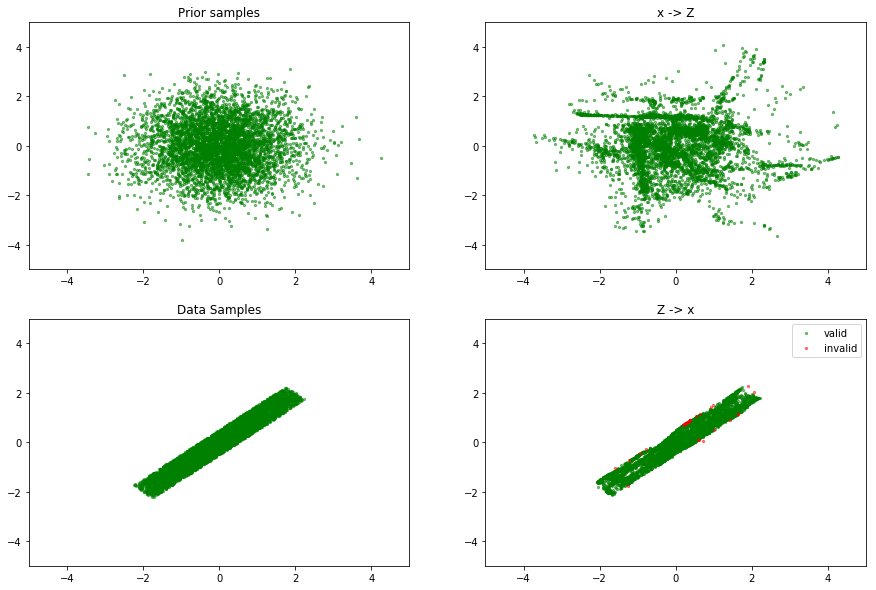

# generated: 5000
# broken constraint: 60
% broken constraint: 0.012


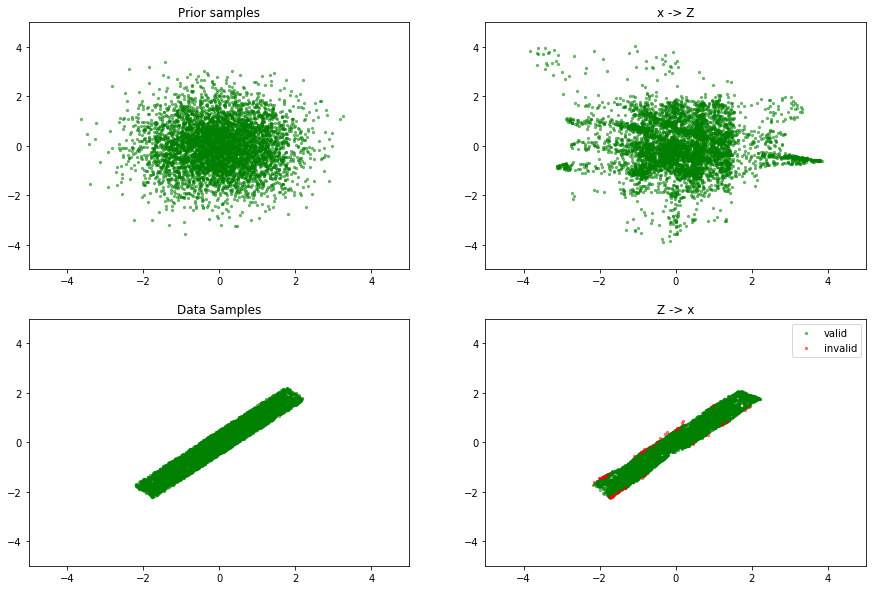

# generated: 5000
# broken constraint: 70
% broken constraint: 0.014


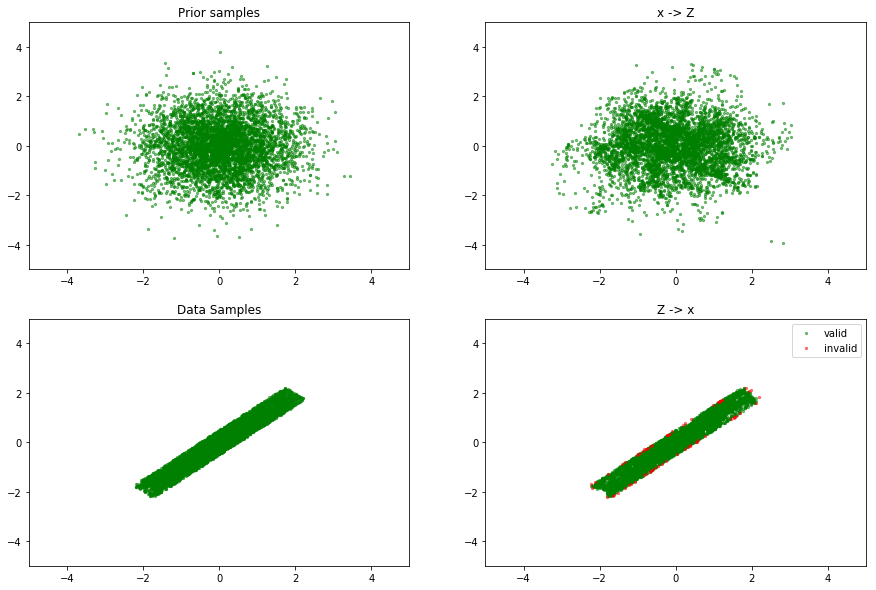

# generated: 5000
# broken constraint: 95
% broken constraint: 0.019


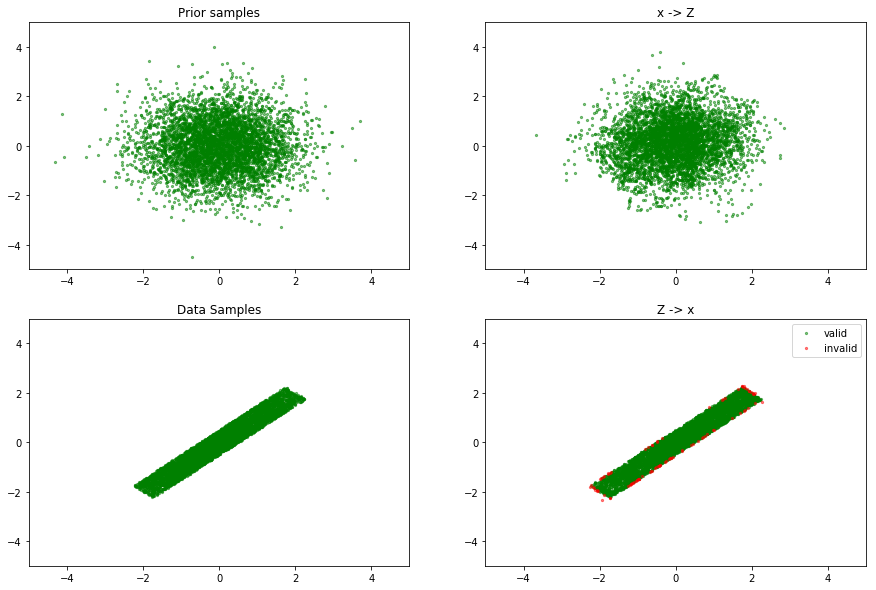

# generated: 5000
# broken constraint: 81
% broken constraint: 0.0162


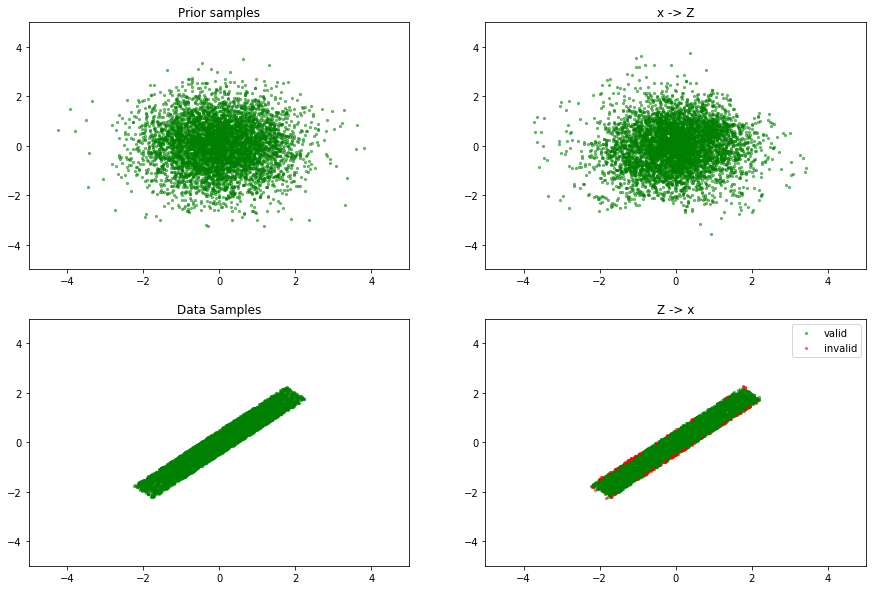

# generated: 5000
# broken constraint: 80
% broken constraint: 0.016


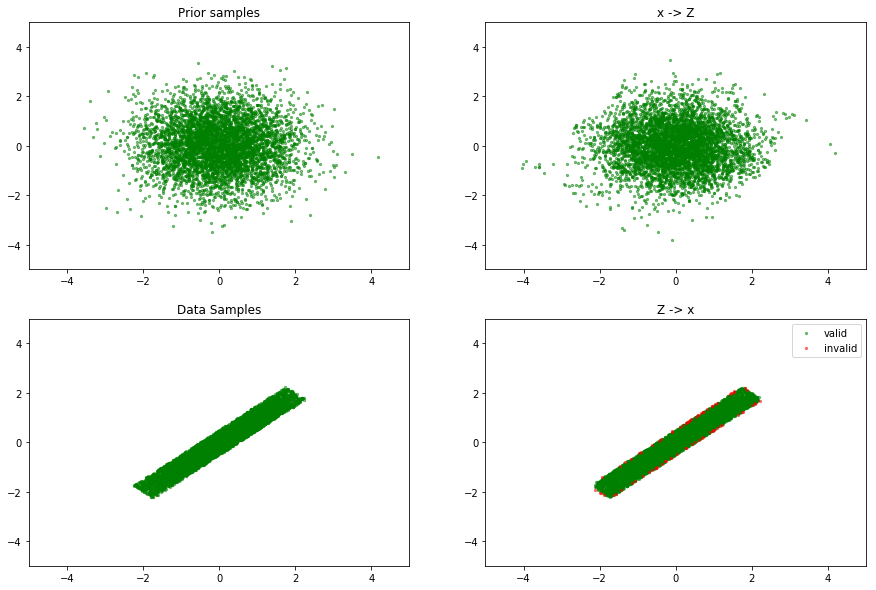

In [62]:
for mdl in models_back: 
#     mdl = build_model(baseline=True, num_layers=5)
#     mdl.load_state_dict(r['model_no_back'])
    mdl.eval()

    plot_model(d, mdl, constraint=d.hard_constraint)